In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

# from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,LSTM, Dense, Flatten, Conv1D, Lambda, Reshape
from keras.layers.merge import concatenate, multiply,add
import tensorflow as tf
from keras import regularizers
from keras.initializers import glorot_uniform
from tqdm import tqdm
import rpy2
import rpy2.robjects.numpy2ri
from stldecompose import decompose
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr
from keras import regularizers

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
stats = importr('stats')
stl=stats.stl
ts =stats.ts
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [2]:
# d ="/home/chatta/ICML/M3/"
d ="/home/chatta/ICML/nn5/"
# xls = pd.ExcelFile(d+'M3C.xls')
# data=pd.read_excel(xls,'M3Month')
# data = pd.read_csv(d+"cif_dataset_complete.csv",header=None)
data = pd.read_csv(d+"NN5_interpolated.csv",header=None)
predictions = pd.read_csv(d+'final_theta/theta_50_horg.csv',index_col=0,skiprows = [1])
# theta1 = pd.read_csv(d+'1st_theta_300.csv',ind1ex_col=0)
data_length = data.shape[0]


In [3]:
def make_input(data,window_size,horizon=1):
    length=data.shape[0]
#     depth=data.shape[2]
    y = np.zeros([length-window_size+1-horizon,horizon])
    output=np.zeros([length-window_size+1-horizon,window_size])
    for i in range(length-window_size-horizon+1):
        output[i:i+1,:]=data[i:i+window_size]
        y[i,:]= data[i+window_size:i+window_size+horizon]
    return output.reshape(output.shape[0],window_size,1), y

def make_k_input(data,window_size,horizon):
    length = data.shape[0]
    output= np.zeros([length-window_size+1-horizon,horizon])
    for i in range(length-window_size-horizon+1):
        output[i:i+1,:]=data[i+window_size:i+window_size+horizon]
    return output.reshape(output.shape[0],horizon,1)


In [4]:
def nonov_make_input(data,window_size,horizon=1):
    length=data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon
#     print(str(extra))
    data = np.append(data,np.zeros([horizon-extra]))
#     print(data)
    
    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
        
    output=np.zeros([i_val,window_size])
    y=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[i*horizon:(i*horizon)+window_size]
        y[i,:]= data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
        
    return output.reshape(output.shape[0],window_size,1), y

def nonov_make_k_input(data,window_size,horizon):
    length = data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon
    data_app = np.repeat(data[-1],extra)
    data = np.append(data,data_app)
#     data = np.append(data,np.zeros([horizon-extra]))
    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
    output=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
    return output.reshape(output.shape[0],horizon,1)    

In [5]:
with tqdm(total=data_length) as pbar:
    for horizon in [1]:
        
        
    
        
        final_predictions = np.zeros([data_length,56]) #-----change
        for y in range(data_length):
            
#             n_test = data.iloc[y].values[2] #----cif
            n_test = 56
            horizon=56
            
            window_size=25
#             if horizon==6:
#                 window_size=7
#             else:
#                 window_size=15
           
#             nn_val =np.asarray(data.loc[y][3:].dropna().values,dtype=float) #-----cif
            nn_val= np.asarray(data.iloc[y].dropna().values,dtype=float)

            rr = nn_val.size
            rr = int(np.floor(rr*.25))
            temp1=nn_val[2*rr:] #--------------check
#             temp1=np.asarray(data.loc[y].dropna().values,dtype=float)[300:]
           
            epsilon = 0.05
            temp1[temp1<epsilon] = temp1[temp1<epsilon]+0.05
            series = np.log(temp1)
#             series = temp1


            frequency = 7           
            if temp1.size < 2*frequency:
                frequency=2            
            
        
            

            
            result = stl(ts(series,frequency=frequency),"periodic")
            temp=pandas2ri.ri2py(result.rx2('time.series'))
            series_1  = temp[:,1]
#             series_1  = temp[:,0]+temp[:,2]
            
            t_v_data = series_1[:-n_test]            
            series_length = t_v_data.size
            n_val = int(np.round(series_length*.2))
            if n_val < horizon:
                n_val = horizon

            train = t_v_data[:-n_val]
            if train.size <11:
                window_size=3
            test = series_1[-(n_test+window_size):]            
#             train = t_v_data[:-n_val]
            val = t_v_data[-(n_val+window_size):]
#             resea=temp[:,1][-n_test:]

            

            temp_theta1= np.asarray(predictions.iloc[y].dropna().values,dtype=float)
            temp_theta1[np.argwhere(temp_theta1<=0)]=0.5
            temp_theta1 = np.log(temp_theta1)
            result_k = stl(ts(temp_theta1,frequency=frequency),"periodic")
            temp_theta=pandas2ri.ri2py(result_k.rx2('time.series'))
            series_k_org = temp_theta[:,1]
#             series_k_org = temp_theta[:,2]+temp_theta[:,0]
            
        
#             temp_theta= np.log(temp_theta)-temp[:,0]
            temp2= series_k_org[:-n_test]
            test_theta = series_k_org[-(n_test+window_size):]
            resea=temp[:,0][-n_test:]

            
            
            
            temp2_train = temp2[:-n_val]
            temp2_val = temp2[-(n_val+window_size):]            
            train_sequence = make_input(train, window_size,horizon)
            val_sequence = make_input(val,window_size,horizon)
            test_sequence = nonov_make_input(test,window_size,horizon)
            
            k_train = make_k_input(temp2_train,window_size,horizon)
            k_train_input = np.repeat(k_train,window_size,axis=1)            
            k_val = make_k_input(temp2_val,window_size,horizon)
            k_val_input = np.repeat(k_val,window_size,axis=1)
            k_test = nonov_make_k_input(test_theta,window_size,horizon)
            k_test_input = np.repeat(k_test,window_size,axis=1)
            
            x_train = train_sequence[0]#.reshape(train_sequence[0].shape[0],window_size,1)
            y_train =train_sequence[1]#-train_sequence[0][:,window_size-1,:].reshape(train_sequence[0].shape[0],1)
            x_val = val_sequence[0]#-val_sequence[0][:,window_size-1,:].reshape(val_sequence[0].shape[0],1,1)#.reshape(val_sequence[0].shape[0],window_size,1)
            y_val = val_sequence[1]#-val_sequence[0][:,window_size-1,:].reshape(val_sequence[0].shape[0],1)
            x_test = test_sequence[0]#-test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1,1)#.reshape(val_sequence[0].shape[0],window_size,1)
            y_test = test_sequence[1]#-test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1)
            
            

            
            
            train_input = np.append(x_train,k_train,axis=1)#-train_sequence[0][:,window_size-1,:].reshape(train_sequence[0].shape[0],1,1)
            val_input = np.append(x_val,k_val,axis=1)#-val_sequence[0][:,window_size-1,:].reshape(val_sequence[0].shape[0],1,1)
            test_input = np.append(x_test,k_test,axis=1)#-test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1,1)
            
           
            k_train=k_train.reshape(k_train.shape[0],horizon)
            k_val=k_val.reshape(k_val.shape[0],horizon)
            k_test=k_test.reshape(k_test.shape[0],horizon)
            

           

            tf.reset_default_graph()
            K.clear_session()

            inputs_n= Input(batch_shape=(None,window_size+horizon,1),name='input_n')
            inputs_k=Input(batch_shape=(None,horizon),name='input_k')
            branch_0 = Conv1D(32,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(inputs_n)
            branch_1 = branch_0
            
            branch_0 = Conv1D(32,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(branch_0)
            branch_0 = Conv1D(32,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(branch_0)
            branch_0 = add([branch_0,branch_1])
            
            branch_1 = branch_0
            branch_0 = Conv1D(32,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(branch_0)
            branch_0 = Conv1D(32,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(branch_0)
            branch_0 = add([branch_0,branch_1])
            
            branch_1 = branch_0
            branch_0 = Conv1D(32,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(branch_0)
            branch_0 = Conv1D(32,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(branch_0)
            branch_0 = add([branch_0,branch_1])              
            branch_0=Flatten()(branch_0)
            net= Dense(horizon,name='dense_final',activity_regularizer=regularizers.l2(0.05))(branch_0)
            net=add([net,inputs_k])
            #-----------------asdasdasdasdasd----------------------------------
            model=Model(inputs=[inputs_n,inputs_k],outputs=net)
            opt = Adam(lr=0.0001)
            callback = ModelCheckpoint(filepath=d+'nn5.h5',monitor='val_loss',save_best_only=True,save_weights_only=True)

            model.compile(loss='mean_squared_error',
                          optimizer=opt)
           
            model.fit({'input_n':train_input, 'input_k':k_train},y_train,validation_data=[[val_input,k_val],y_val],callbacks=[callback],shuffle=True,batch_size=8, epochs=100,verbose=0)
#             validation_data=[[test_input,k_test],y_test],callbacks=[callback]
            model.load_weights(d+'nn5.h5')
            pred=model.predict({'input_n':test_input, 'input_k':k_test})
            pred=pred.reshape(pred.size)[:n_test]
#             pred_final= pred.reshape(n_test)#+test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1))
#             helo_temp=pred[0,:]
#             for i in range(pred.shape[0]-1):
#                 helo_temp=np.append(helo_temp,pred[i+1,2])
            final_predictions[y,:n_test] = pred.reshape(n_test)
            pbar.update(1)
        np.savetxt(d+'final/50_trend_horg.csv',final_predictions, fmt='%1.3f',delimiter=',')

100%|██████████| 111/111 [31:02<00:00, 16.76s/it]


In [24]:
[mse(test_theta[-n_test:],test[-n_test:]),mse(pred.reshape(n_test),test[-n_test:])]

[0.025401281043541533, 0.019337569432457086]

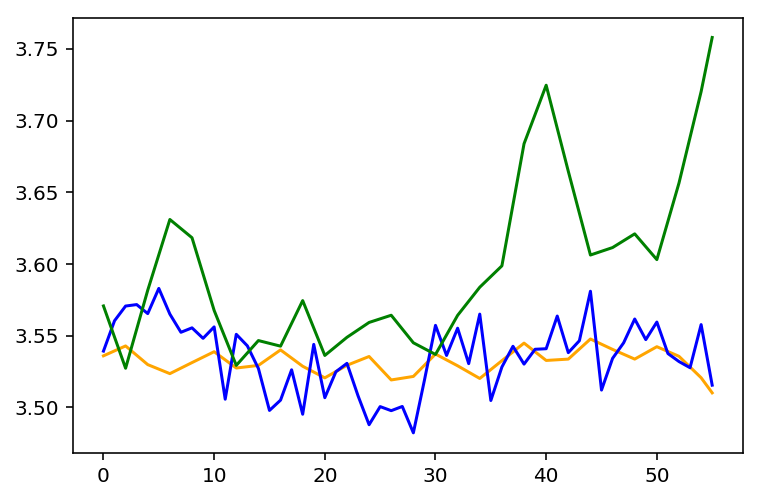

In [12]:
plt.plot(test_theta[-n_test:],color='orange')
plt.plot(pred,color='blue')
plt.plot(test[-(n_test):],color='green')

In [173]:
final_mape=np.zeros([1,2])
d ="/home/chatta/ICML/CIF2016/"
# temp=0
# for s in ['Year','Quart','Other','Month']:
# xls = pd.ExcelFile(d+'M3C.xls')
# data = pd.read_csv(d+'NN5_interpolated.csv',header=None)
data = pd.read_csv(d+'cif_dataset_complete.csv',header=None)

predictions = pd.read_csv(d+'theta_25_datafit_h3.csv',index_col=0,skiprows = [1])
data_length=data.shape[0]

lstm_k = pd.read_csv(d+'trend_preds_h3.csv',header=None)
mape = np.zeros([data_length,2])
mse_err = np.zeros([data_length,2])
# horizon=56
for i in range(data_length):
    horizon = data.loc[y][1]
    #     if s == 'Year':
#         horizon=6
#     elif s == 'Month':
#         horizon = 18
#     else:
#         horizon = 8

#     temp1=np.asarray(data.loc[i].dropna().values,dtype=float)[300:]


    nn_val =np.asarray(data.loc[i][3:].dropna().values,dtype=float) #-----cif
    rr = nn_val.size
    rr = int(np.floor(rr*.25))
    temp1=nn_val[rr:]
    frequency =12           
    if temp1.size < 2*frequency:
        frequency=7
    epsilon = 0.05
    temp1[temp1<epsilon] = temp1[temp1<epsilon]+0.05
    series = np.log(temp1)
    result = stl(ts(series,frequency=frequency),"periodic")
    temp=pandas2ri.ri2py(result.rx2('time.series'))
    val  = temp[:,1]
    val = val[-horizon:]
    zero_indexes = np.argwhere(val==0)
    val =np.delete(val,zero_indexes,None)
    temp_theta1= np.asarray(predictions.iloc[i].dropna().values,dtype=float)
    temp_theta1[np.argwhere(temp_theta1<=0)]=0.5
    temp_theta1 = np.log(temp_theta1)
    result_k = stl(ts(temp_theta1,frequency=frequency),"periodic")
    temp_theta=pandas2ri.ri2py(result_k.rx2('time.series'))
    preds= temp_theta[:,1]
    preds=preds[-horizon:]
    preds = np.delete(preds,zero_indexes,None)
#     preds_k = np.asarray(lstm_k.loc[i,:])
    preds_k = np.asarray(lstm_k.iloc[i].values,dtype=float)[:horizon]
    preds_k  = np.delete(preds_k,zero_indexes,None)
#     print(sMAPE(val,preds))

    mape[i,0] = sMAPE(val,preds,horizon)
    mape[i,1] = sMAPE(val,preds_k,horizon)
    mse_err[i,0] = mse(val,preds)
    mse_err[i,1] =mse(val,preds_k)
#         print(mape.shape)
#     break
avg_mape  = np.sum(mape,axis=0)/data_length
avg_mse  = np.sum(mse_err,axis=0)/data_length

#         print(avg_mape.shape)
#         break
final_mape[0,:] = avg_mape
# temp+=1
final_avg_mape = np.sum(final_mape,axis=0)/final_mape.shape[0]

In [174]:
avg_mape

array([0.02111259, 0.02177947])

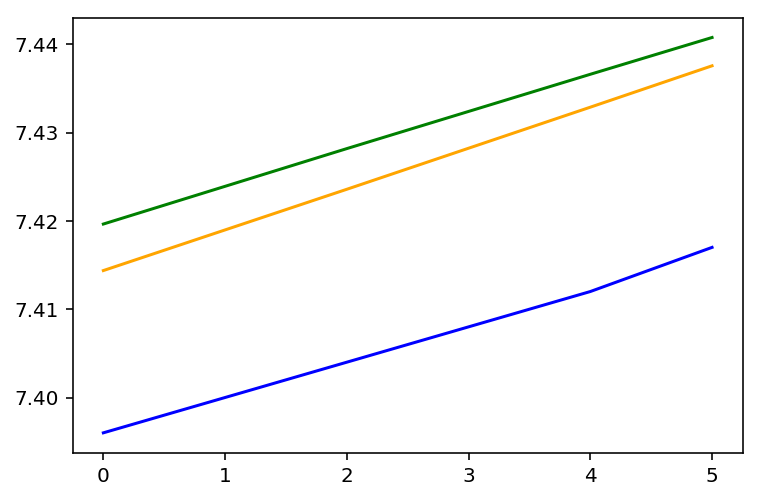

In [121]:
plt.plot(preds[-n_test:],color='orange')
plt.plot(preds_k,color='blue')
plt.plot(val,color='green')

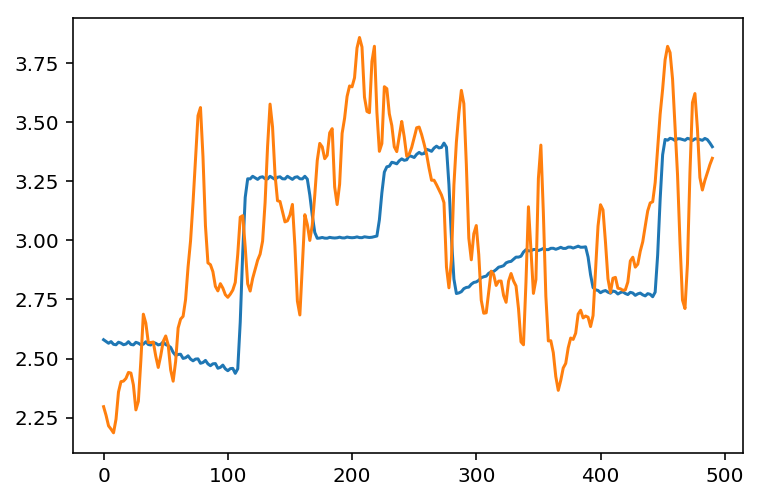

In [51]:
plt.plot(temp_theta[:,1])
plt.plot(temp[:,1])

In [35]:
temp1

array([8.48200000e+00, 9.46900000e+00, 1.04810000e+01, 1.78060000e+01,
       2.10420000e+01, 1.92530000e+01, 7.79900000e+00, 9.81100000e+00,
       9.86300000e+00, 1.03100000e+01, 1.64910000e+01, 2.36450000e+01,
       1.93580000e+01, 1.09280000e+01, 1.07970000e+01, 1.12050000e+01,
       1.00740000e+01, 1.44920000e+01, 2.79980000e+01, 2.11470000e+01,
       4.15600000e+00, 8.24600000e+00, 9.31100000e+00, 1.17040000e+01,
       1.99110000e+01, 2.62490000e+01, 3.45900000e+00, 1.73990000e+01,
       1.48080000e+01, 1.34400000e+01, 1.06650000e+01, 1.39790000e+01,
       2.33040000e+01, 1.94240000e+01, 1.71750000e+01, 1.14020000e+01,
       1.07710000e+01, 9.85000000e+00, 1.92140000e+01, 2.67750000e+01,
       1.66620000e+01, 8.12700000e+00, 1.18490000e+01, 1.29270000e+01,
       1.29670000e+01, 2.19100000e+01, 3.39950000e+01, 2.10420000e+01,
       9.53400000e+00, 1.03100000e+01, 1.03370000e+01, 1.15730000e+01,
       1.64910000e+01, 2.72880000e+01, 2.24750000e+01, 3.69500000e+00,
      

In [23]:
#-------------NN5-----------------------
final_mape=np.zeros([1,2])
d ="/home/chatta/ICML/NN5/"
# temp=0
# for s in ['Year','Quart','Other','Month']:
# xls = pd.ExcelFile(d+'M3C.xls')
# data = pd.read_csv(d+'NN5_interpolated.csv',header=None)
# predictions = pd.read_csv(d+'theta_300_datafit.csv',index_col=0,skiprows = [1])
data = 
data_length=data.shape[0]

lstm_k = final_predictions
mape = np.zeros([data_length,2])
mse_err = np.zeros([data_length,2])
horizon=56
for i in range(data_length):
#     if s == 'Year':
#         horizon=6
#     elif s == 'Month':
#         horizon = 18
#     else:
#         horizon = 8

    val=np.asarray(data.loc[i].dropna().values,dtype=float)[-horizon:]
    zero_indexes = np.argwhere(val==0)
    val =np.delete(val,zero_indexes,None)
    preds=np.asarray(predictions.iloc[i].dropna().values,dtype=float)[-horizon:]
    preds = np.delete(preds,zero_indexes,None)
#     preds_k = np.asarray(lstm_k.loc[i,:])
    preds_k = lstm_k[i,:]
    preds_k  = np.delete(preds_k,zero_indexes,None)
#     print(sMAPE(val,preds))

    mape[i,0] = sMAPE(val,preds,horizon)
    mape[i,1] = sMAPE(val,preds_k,horizon)
    mse_err[i,0] = mse(val,preds)
    mse_err[i,1] =mse(val,preds_k)
#         print(mape.shape)
#     break
avg_mape  = np.sum(mape,axis=0)/data_length
avg_mse  = np.sum(mse_err,axis=0)/data_length
#         print(avg_mape.shape)
#         break
final_mape[0,:] = avg_mape
# temp+=1
final_avg_mape = np.sum(final_mape,axis=0)/final_mape.shape[0]

SyntaxError: invalid syntax (<ipython-input-23-b5b4a68db296>, line 9)

In [22]:
avg_mse1=

array([0.08966759, 0.08772805])

In [34]:
mape

<function sklearn.metrics.regression.mean_squared_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average')>

In [35]:
mse_err

array([[8.19858828e-05, 9.86083923e-04],
       [1.97262895e-04, 7.26934824e-04],
       [3.15327397e-03, 5.02786997e-03],
       [4.33116399e-05, 5.82553302e-03],
       [1.77319572e-03, 3.04991992e-02],
       [1.29699724e-03, 2.39834577e-02],
       [9.83241154e-05, 1.03114038e-04],
       [4.50148622e-05, 3.89608401e-05],
       [6.94481204e-04, 2.14364084e-03],
       [1.35465056e-03, 1.77232890e-02],
       [5.18323660e-05, 5.64385744e-04],
       [1.23816616e-04, 2.01220686e-03],
       [5.03338049e-04, 1.02901687e-03],
       [5.38712447e-04, 2.83108557e-03],
       [1.20582629e-02, 8.17570220e-03],
       [3.75714190e-03, 9.50409880e-03],
       [1.47549124e-02, 4.99638542e-02],
       [2.47779209e-02, 5.42322312e-02],
       [2.00130598e-03, 3.34261313e-03],
       [8.27702140e-04, 6.95549413e-04],
       [9.42644574e-03, 7.71545406e-03],
       [5.18016606e-03, 1.55448287e-02],
       [1.22336562e-03, 7.71574396e-04],
       [6.35798003e-03, 6.03121377e-03],
       [3.758667

In [ ]:
avg_mse1 = np.log(mse)

In [10]:
mse(pred_final,temp1[-n_test:])

105.1727076581003

In [6]:
def sMAPE(val,preds,horizon):
    temp = np.abs(val-preds)
    temp1=np.abs(val)+np.abs(preds)
    
    smape = 2/horizon*np.sum(temp/temp1)

    return smape

In [160]:
sMAPE(temp1[-n_test:],np.exp(temp_theta1[-n_test:]))

0.03126377375932253

In [ ]:
mape = np.zeros([data_length])
for i in range(data_length):
    
    val=np.asarray(data.loc[i][6:].dropna().values,dtype=float)[-6:]
    preds=final_predictions[i,:]
#     print(sMAPE(val,preds))
    mape[i] = sMAPE(val,preds)
#     print(mape[i])
#     break
avg_mape  = np.sum(mape)/data_length
avg_mape